# Fundamental diagrams

The nonlinearities inherent in traffic flow are captured by the so-called [fundamental diagrams](https://en.wikipedia.org/wiki/Fundamental_diagram_of_traffic_flow#/media/File:Fundamental_Diagram.PNG). Try to re-make the fundamental diagrams from our data.

In [140]:
using CSV
using DataFrames
using Statistics
using KFactors
using Plots
using RawArray
using CategoricalArrays
using Printf
using RollingFunctions
using StatsBase
using Distributions

In [2]:
data_raw = raread("../data/fundamental_diagram.ra");

In [10]:
data = dropdims(sum(data_raw, dims=4), dims=4);

In [11]:
# define human-readable names for axes
const SPEED = 1
const FLOW = 2
const DENS = 3

3

In [12]:
# resample an array to be smaller by averaging adjacent cells
function resample(array, blocksize)
    shp = ceil.(Int64, size(array) ./ blocksize)
    out = zeros(Float64, shp)
    
    for x in 1:shp[1]
        for y in 1:shp[2]
            xfr = (x - 1) * blocksize[1] + 1
            xto = min(x * blocksize[1], size(array)[1])
            yfr = (y - 1) * blocksize[2] + 1
            yto = min(y * blocksize[2], size(array)[2])
            out[x, y] = mean(@view array[xfr:xto, yfr:yto])
        end
    end
    
    out
end

resample (generic function with 1 method)

In [13]:
function toquantiles(vector, n; skipzero=false)
    if skipzero
        qvector = filter(x -> x != 0, reshape(vector, :))
    else
        qvector = reshape(vector, :)
    end
    # n + 1 b/c both 0 and 1 are in range, so 0:0.1:1 is 11 values
    probs = range(0, 1; length=n + 1)
    quantiles = quantile(qvector, probs)
    
    map(x -> probs[findfirst(x .≤ quantiles)], vector)
end

toquantiles (generic function with 1 method)

In [14]:
# insert commas in numbers
# https://stackoverflow.com/questions/52213829
function commas(num::Integer)
    str = string(num)
    return replace(str, r"(?<=[0-9])(?=(?:[0-9]{3})+(?![0-9]))" => ",")
end

commas (generic function with 1 method)

In [280]:
sampsize = sum(data)

5995994378

In [281]:
function normalkernel(arr, scale)
    if scale isa Number
        scale = fill(scale, length(arr))
    end
        
    map(1:length(arr)) do i
        dist = Normal(i, scale[i])
        wgts = pdf.(dist, 1:length(arr))
        sum(arr .* wgts)
    end
end


function getlines(arr;scale=5)
    xs = 1:size(arr)[1]
    
    ys = map(xs) do x
        argmax(arr[x,:])
    end
    
    xs, normalkernel(ys, scale)
end

getlines (generic function with 3 methods)

In [282]:
speed_flow = resample(dropdims(sum(data, dims=DENS), dims=DENS), (1, 2))
# Do this as a map from speed to flow due to nonmonotonicity
speed_flow_y, speed_flow_x = getlines(speed_flow)

speed_flow = toquantiles(speed_flow, 30, skipzero=true);

In [283]:
speed_density = resample(dropdims(sum(data, dims=FLOW), dims=FLOW), (3, 2))
# smooth less aggresively at start to avoid averaging in many lower values
speed_density_x, speed_density_y = getlines(transpose(speed_density), scale=vcat(range(0.45, 5, 10), fill(5, 122)))
speed_density = toquantiles(speed_density, 30, skipzero=true);

In [284]:
dens_flow = resample(dropdims(sum(data, dims=SPEED), dims=SPEED), (2, 2))
# smooth not very much early on, so we don't average in too many higher values when we don't
# have lower values in the average
# expand the window and smooth more aggressively as we get to sparser data
# https://xkcd.com/2048/
dens_flow_x, dens_flow_y = getlines(transpose(dens_flow), scale=vcat(1:5, fill(5, 45), range(5, 50, 82)))
dens_flow = toquantiles(dens_flow, 30, skipzero=true);

In [336]:
0:250:2250

0:250:2250

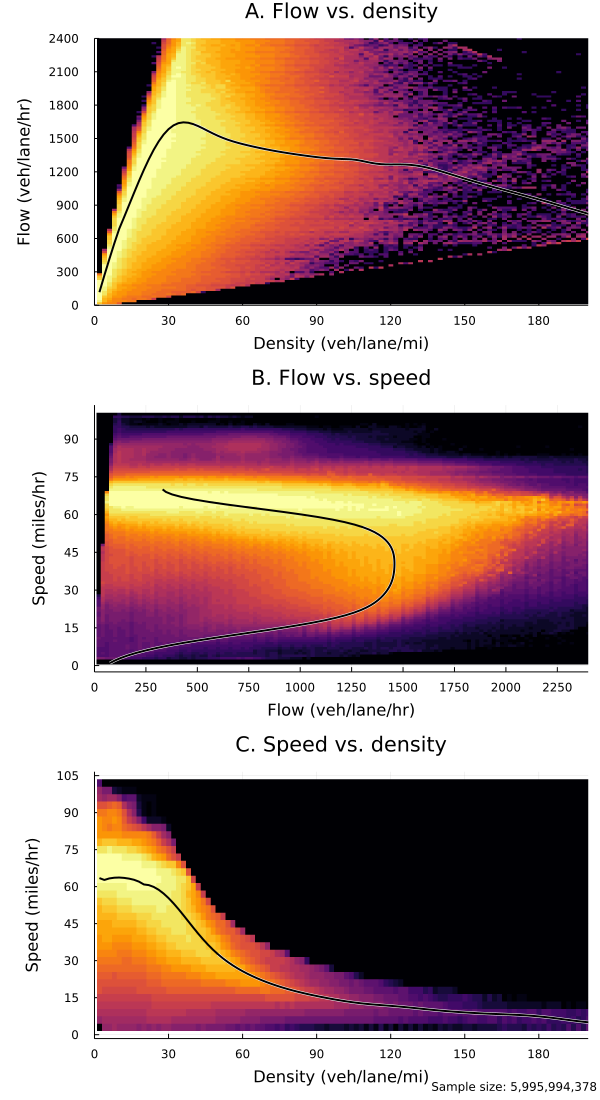

In [343]:
speed_flow_plot = heatmap(speed_flow, yticks=0:15:100, xticks=(0:25//2:115, (0:250:2250)), legend=false)
plot!(speed_flow_x[1:55], speed_flow_y[1:55], color="white", linewidth=3)
plot!(speed_flow_x[1:70], speed_flow_y[1:70], color="black", linewidth=2)
xlims!(speed_flow_plot, 0, 2400 / 20)
ylabel!(speed_flow_plot, "Speed (miles/hr)")
xlabel!(speed_flow_plot, "Flow (veh/lane/hr)")
title!(speed_flow_plot, "B. Flow vs. speed")

speed_dens_plot = heatmap(speed_density, yticks=(0:5:35, (0:5:35) .* 3), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(speed_density_x[25:end], speed_density_y[25:end], color="white", linewidth=3)
plot!(speed_density_x, speed_density_y, color="black", linewidth=2)
xlabel!(speed_dens_plot, "Density (veh/lane/mi)")
ylabel!(speed_dens_plot, "Speed (miles/hr)")
xlims!(0, 100)
annotate!(speed_dens_plot, 85, -7, text("Sample size: $(commas(sampsize))", pointsize=8))
title!(speed_dens_plot, "C. Speed vs. density")

dens_flow_plot = heatmap(dens_flow, yticks=(0:15:120, (0:15:120) .* 20), xticks=(0:15:90, (0:15:90) .* 2), legend=false)
plot!(dens_flow_x[20:end], dens_flow_y[20:end], color="white", linewidth=3)
plot!(dens_flow_x, dens_flow_y, color="black", linewidth=2)
xlabel!(dens_flow_plot, "Density (veh/lane/mi)")
ylims!(0, 2400/20)
xlims!(0, 100)
ylabel!(dens_flow_plot, "Flow (veh/lane/hr)")
title!(dens_flow_plot, "A. Flow vs. density")

plot(dens_flow_plot, speed_flow_plot, speed_dens_plot, layout=grid(3, 1), size=(600, 1100), left_margin=10Plots.mm)
savefig("../fig/fundamental_diagrams.pdf")
plot!()


In [335]:
dens_flow

150×132 Matrix{Float64}:
 0.866667  0.766667  0.733333  0.733333  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.966667  0.833333  0.766667  0.733333     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.833333  0.8       0.733333     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.866667  0.833333  0.766667     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.933333  0.833333  0.8          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.933333  0.866667  0.8       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.966667  0.866667  0.833333     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.966667  0.9       0.866667     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       1.0       0.933333  0.866667     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       1.0       0.933333  0.866667     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       1.0       0.966667  0.9       …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.9       1.0       0.966667  0.9          0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.866667  1.0       0.966667  0.933333

In [51]:
(0:5:35) .* 3

0:15:105